# Proyecto para predecir el fraude financiero en los sistemas de pagos

Este proyecto es desarrollado por: \
    Luis Daniel Trujillo \
    Jair Castro\
    Diego Ramirez

Fue construido en Python versión 3.8 utilizando Jupyter Book como interprete de Python y Visual Studio Code como editor de codigo.

## 1. Import de la base

In [2]:
# Cargue de las librerias

import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.lines as mlines
from mpl_toolkits.mplot3d import Axes3D
from pandas_profiling import ProfileReport
from sklearn.model_selection import train_test_split, learning_curve
from sklearn.metrics import average_precision_score

from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import LeaveOneOut
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn import preprocessing 

In [3]:
import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning)

In [4]:
# Import de la base de datos
df = pd.read_csv("D:\OneDrive - Universidad del Norte\Documentos\Maestría Estadística\Semestre III\Machine Learning\Proyecto/PS_20174392719_1491204439457_log.csv")

In [5]:
# Renombrando a las variables
df = df.rename(columns={'oldbalanceOrg':'oldBalanceOrig', 'newbalanceOrig':'newBalanceOrig', \
                        'oldbalanceDest':'oldBalanceDest', 'newbalanceDest':'newBalanceDest'})
print(df.head())

   step      type    amount     nameOrig  oldBalanceOrig  newBalanceOrig  \
0     1   PAYMENT   9839.64  C1231006815        170136.0       160296.36   
1     1   PAYMENT   1864.28  C1666544295         21249.0        19384.72   
2     1  TRANSFER    181.00  C1305486145           181.0            0.00   
3     1  CASH_OUT    181.00   C840083671           181.0            0.00   
4     1   PAYMENT  11668.14  C2048537720         41554.0        29885.86   

      nameDest  oldBalanceDest  newBalanceDest  isFraud  isFlaggedFraud  
0  M1979787155             0.0             0.0        0               0  
1  M2044282225             0.0             0.0        0               0  
2   C553264065             0.0             0.0        1               0  
3    C38997010         21182.0             0.0        1               0  
4  M1230701703             0.0             0.0        0               0  


## 2. Análisis Exploratorio de Datos

### 2.1. Transacciones fraudulentas
De los cinco tipos de transacciones, el fraude solo ocurre en dos de ellas: _Transfer_ que es cuando se envía dinero a un cliente del banco (o en su defecto, estafador) y _Cash out_ que es cuando se envía dinero a un comerciante para que le pague al cliente (o estafador).  

In [6]:
print('\n Los tipos de transacciones fraudulentas son {}'.format(\
list(df.loc[df.isFraud == 1].type.drop_duplicates().values))) 
                                                             

dfFraudTransfer = df.loc[(df.isFraud == 1) & (df.type == 'TRANSFER')] 
dfFraudCashout = df.loc[(df.isFraud == 1) & (df.type == 'CASH_OUT')] 

print ('\n El número de transferencias fraudulentas es = {}'.\
       format(len(dfFraudTransfer))) 

print ('\n El número de retiros fraudulentos es = {}'.\
       format(len(dfFraudCashout))) 


 Los tipos de transacciones fraudulentas son ['TRANSFER', 'CASH_OUT']

 El número de transferencias fraudulentas es = 4097

 El número de retiros fraudulentos es = 4116


### 2.2. Transacciones con alerta de fraude
Dentro de los tipos de transacciones donde se generó una alerta por posible fraude, solo se encuentró el tipo de transacción *transferencia*. Donde, el monto **mínimo** alertado fue de 353.874,22 usd y el **máximo** de 92.445.516,64 usd.

In [7]:
print('\nTipos de transacciones en donde se activa la alerta de fraude: \
{}'.format(list(df.loc[df.isFlaggedFraud == 1].type.drop_duplicates()))) 
                                                            

dfTransfer = df.loc[df.type == 'TRANSFER']
dfFlagged = df.loc[df.isFlaggedFraud == 1]
dfNotFlagged = df.loc[df.isFlaggedFraud == 0]

print('\nCantidad mínima en donde se activa la alerta de fraude = {}'\
                                  .format(dfFlagged.amount.min())) 

print('\nCantidad máxima donde se activa la alerta de fraude =\
 {}'.format(dfTransfer.loc[dfTransfer.isFlaggedFraud == 0].amount.max())) 


Tipos de transacciones en donde se activa la alerta de fraude: ['TRANSFER']

Cantidad mínima en donde se activa la alerta de fraude = 353874.22

Cantidad máxima donde se activa la alerta de fraude = 92445516.64


En las transacciones con alerta de fraude se puede identificar que el antiguo y nuevo balance es el mismo en las cuentas de origen y destino. Además, en las transacciones del mismo tipo el antiguo balance de la cuenta destino = 0. Sin embargo, hay transferencias en donde el antiguo y el nuevo balance de la cuenta destino son iguales 0 y no son marcadas como alerta de fraude. Así que esta condición no determina que una transacción sea marcada como alerta de fraude. En conclusión esta variable será descartada.

In [8]:
df.loc[df.isFlaggedFraud == 1]

,step,type,amount,nameOrig,oldBalanceOrig,newBalanceOrig,nameDest,oldBalanceDest,newBalanceDest,isFraud,isFlaggedFraud
2736446,212,TRANSFER,4953893.08,C728984460,4953893.08,4953893.08,C639921569,0.0,0.0,1,1
3247297,250,TRANSFER,1343002.08,C1100582606,1343002.08,1343002.08,C1147517658,0.0,0.0,1,1
3760288,279,TRANSFER,536624.41,C1035541766,536624.41,536624.41,C1100697970,0.0,0.0,1,1
5563713,387,TRANSFER,4892193.09,C908544136,4892193.09,4892193.09,C891140444,0.0,0.0,1,1
5996407,425,TRANSFER,10000000.00,C689608084,19585040.37,19585040.37,C1392803603,0.0,0.0,1,1
5996409,425,TRANSFER,9585040.37,C452586515,19585040.37,19585040.37,C1109166882,0.0,0.0,1,1
6168499,554,TRANSFER,3576297.10,C193696150,3576297.10,3576297.10,C484597480,0.0,0.0,1,1
6205439,586,TRANSFER,353874.22,C1684585475,353874.22,353874.22,C1770418982,0.0,0.0,1,1
6266413,617,TRANSFER,2542664.27,C786455622,2542664.27,2542664.27,C661958277,0.0,0.0,1,1
6281482,646,TRANSFER,10000000.00,C19004745,10399045.08,10399045.08,C1806199534,0.0,0.0,1,1


In [9]:
print('\nNúmero de cuentas marcadas como no fraude con antiguo balance de la cuenta de destino igual a 0 y\
 nuevo balance de la cuenta de destino igual a 0: {}'.\
format(len(dfTransfer.loc[(dfTransfer.isFlaggedFraud == 0) & \
(dfTransfer.oldBalanceDest == 0) & (dfTransfer.newBalanceDest == 0)]))) 


Número de cuentas marcadas como no fraude con antiguo balance de la cuenta de destino igual a 0 y nuevo balance de la cuenta de destino igual a 0: 4158


### 2.3. Cash in

En esta modalidad de fraude, se le transfiere el dinero a una cuenta (comerciante) que le paga a el estafador. En este caso puede suceder que la cuenta que recibe el dinero sea la misma del estafador. Sin embargo, los datos muestran que no hay cuentas comunes.

In [10]:
print('\nHay comerciantes entre las cuentas de origen para las trasacciones de pago \
en efectivo? {}'.format(\
(df.loc[df.type == 'CASH_IN'].nameOrig.str.contains('M')).any())) 


Hay comerciantes entre las cuentas de origen para las trasacciones de pago en efectivo? False


### 2.4. Cash out
De igual manera sucede con Cash out. No hay cuentas comunes entre las transacciones y las cuentas que sacan el dinero.

In [11]:
print('\nHay comerciantes entre las cuenta de destino para las trasacciones de retiro \
de efefctivo? {}'.format(\
(df.loc[df.type == 'CASH_OUT'].nameDest.str.contains('M')).any())) 


Hay comerciantes entre las cuenta de destino para las trasacciones de retiro de efefctivo? False


De hecho, no hay comerciantes entre las cuentas que envian dinero. Solo están en las cuentas que reciben.

In [12]:
print('\nHay comerciantes entre las cuentas de origen? {}'.format(\
      df.nameOrig.str.contains('M').any())) 
#
print('\nHay otro tipo de transaccion diferente a pagos para \
 los comerciantes? {}'.format(\
(df.loc[df.nameDest.str.contains('M')].type != 'PAYMENT').any())) 


Hay comerciantes entre las cuentas de origen? False

Hay otro tipo de transaccion diferente a pagos para  los comerciantes? False


En conclusión, para todas las transacciones  teniendo en cuenta el número de cuenta destino y origen, la etiqueta comerciante aparece de una forma impredecible. Así que esta variable se descarta. 
Dentro de las cuentas receptoras de transferencias puede suceder que algunas cuentas sean originarias de retiros en efectivo. Sin embargo, los datos muestran que no existen esas cuentas.

In [13]:
#  
print('\nDentro de las transacciones fraudulentas hay cuentas destino \
receptoras de dinero para retiro en efectivo? {}'.format(\
(dfFraudTransfer.nameDest.isin(dfFraudCashout.nameOrig)).any())) # False
dfNotFraud = df.loc[df.isFraud == 0]


Dentro de las transacciones fraudulentas hay cuentas destino receptoras de dinero para retiro en efectivo? False


Algunas cuentas de destino para tranferencias fraudulentas originaron retiros de efeftivo que no fueron detectados como fraude y fueron marcados como retiros genuinos. 

In [14]:
print('\nFraudulent TRANSFERs whose destination accounts are originators of \
genuine CASH_OUTs: \n\n{}'.format(dfFraudTransfer.loc[dfFraudTransfer.nameDest.\
isin(dfNotFraud.loc[dfNotFraud.type == 'CASH_OUT'].nameOrig.drop_duplicates())]))


Fraudulent TRANSFERs whose destination accounts are originators of genuine CASH_OUTs: 

         step      type      amount     nameOrig  oldBalanceOrig  \
1030443    65  TRANSFER  1282971.57  C1175896731      1282971.57   
6039814   486  TRANSFER   214793.32  C2140495649       214793.32   
6362556   738  TRANSFER   814689.88  C2029041842       814689.88   

         newBalanceOrig     nameDest  oldBalanceDest  newBalanceDest  isFraud  \
1030443             0.0  C1714931087             0.0             0.0        1   
6039814             0.0   C423543548             0.0             0.0        1   
6362556             0.0  C1023330867             0.0             0.0        1   

         isFlaggedFraud  
1030443               0  
6039814               0  
6362556               0  


## 3. Limpieza de los datos
Del Analisis Exploratorio de Datos (AED) nos dimos cuenta que el fraude ocurre solo en las transferencias y los retiros. Por lo tanto vamos a trabajar con una base que tenga solo ese tipo de transacciones

In [15]:
# Se crea un sub data_frame con solo las transacciones TRANSFER y CASH_OUT
X = df.loc[(df.type == 'TRANSFER') | (df.type == 'CASH_OUT')]

# Se pasa la columna fraude a un objeto llamado Y
Y = X['isFraud']
del X['isFraud']

# Se elimina las columnas irrelevantes para el AED
X = X.drop(['nameOrig', 'nameDest', 'isFlaggedFraud'], axis = 1)


# Se transforma el tipo de transacción en codificación binaria
X.loc[X.type == 'TRANSFER', 'type'] = 0
X.loc[X.type == 'CASH_OUT', 'type'] = 1
X.type = X.type.astype(int) # convert dtype('O') to dtype(int)

### 3.1. Imputación de valores faltantes latentes
La base de datos tiene varias transacciones con balances en 0 en las cuentas receptoras, tanto en el momentos antes y después de una transacción con montos distintos a 0. La proporción de tales transacciones, es mucho más grande en las que son fraudulentas (50%) que en las que son genuinas (0.06%)


In [16]:
# Se separa las observaciones fraudulentas de las que no
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

print('\nLa proporción de transacciones FRAUDULENTAS con \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 aun cuando el monto transado \'amount\' sea distinto de 0 es: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceDest == 0) & \
(Xfraud.newBalanceDest == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nLa proporción de transacciones GENUINAS con \'oldBalanceDest\' = \
\'newBalanceDest\' = 0 aun cuando el monto transado \'amount\' sea distinto de 0 es: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceDest == 0) & \
(XnonFraud.newBalanceDest == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


La proporción de transacciones FRAUDULENTAS con 'oldBalanceDest' = 'newBalanceDest' = 0 aun cuando el monto transado 'amount' sea distinto de 0 es: 0.4955558261293072

La proporción de transacciones GENUINAS con 'oldBalanceDest' = 'newBalanceDest' = 0 aun cuando el monto transado 'amount' sea distinto de 0 es: 0.0006176245277308345


Se hace la misma evaluación para las cuentas de origen

In [17]:
# Se separa las observaciones fraudulentas de las que no
Xfraud = X.loc[Y == 1]
XnonFraud = X.loc[Y == 0]

print('\nLa proporción de transacciones FRAUDULENTAS con \'oldBalanceOrig\' = \
\'newBalanceOrig\' = 0 aun cuando el monto transado \'amount\' sea distinto de 0 es: {}'.\
format(len(Xfraud.loc[(Xfraud.oldBalanceOrig == 0) & \
(Xfraud.newBalanceOrig == 0) & (Xfraud.amount)]) / (1.0 * len(Xfraud))))

print('\nLa proporción de transacciones GENUINAS con \'oldBalanceOrig\' = \
\'newBalanceOrig\' = 0 aun cuando el monto transado \'amount\' sea distinto de 0 es: {}'.\
format(len(XnonFraud.loc[(XnonFraud.oldBalanceOrig == 0) & \
(XnonFraud.newBalanceOrig == 0) & (XnonFraud.amount)]) / (1.0 * len(XnonFraud))))


La proporción de transacciones FRAUDULENTAS con 'oldBalanceOrig' = 'newBalanceOrig' = 0 aun cuando el monto transado 'amount' sea distinto de 0 es: 0.0030439547059539756

La proporción de transacciones GENUINAS con 'oldBalanceOrig' = 'newBalanceOrig' = 0 aun cuando el monto transado 'amount' sea distinto de 0 es: 0.4737321319703598


Dado que el balance en 0 de las cuentas receptoras es un fuerte indicador de fraude, se procede a no hacer imputación del balance de la cuenta (en el momento antes de la transacción) con una distribución con una subsecuente ajuste para los montos transados. Si se hace esto, se maquillaría este indicador de fraude y haría que las transsacciones fraudulentas aparecieran como genuinas. Por lo tanto, se reemplazará el valor de 0 con -1, lo que será más util para la contrucción de un algoritmo de Machine Learning que detecte el fraude.

In [18]:
X.loc[(X.oldBalanceDest == 0) & (X.newBalanceDest == 0) & (X.amount != 0), \
      ['oldBalanceDest', 'newBalanceDest']] = - 1

Así como se demostró, los datos también tienen varias transacciones con balances en 0 en las cuentas de origen, antes y después de una transacción con montos distintos de 0. En este caso la proporción de tales transacciones es mucho menor en los casos de fraude (0.3%) comparado a las transacciones genuinas (47%). De manera similar al razonamiento anterior, en vez de imputar un valor numérico, se reemplaza los 0 con un valor nulo.

In [19]:
#X.loc[(X.oldBalanceOrig == 0) & (X.newBalanceOrig == 0) & (X.amount != 0), \
#      ['oldBalanceOrig', 'newBalanceOrig']] = np.nan

## 4. Ingeniería de variables
En vista de la posibilidad de que las cuentas con balance 0 sirvan para diferenciar entre las transacciones fraudulentas de las que no,  se tomó el proceso de imputación de la sección 3.1 un paso más allá y se creó dos nuevas columnas que registren el error en términos de monto en las cuentas de origen y receptoras para cada transacción. Estas nuevas variables resultaron ser importantes para obtener el mejor desempeño del algoritmo de ML que se usará al final.

In [20]:
X['errorBalanceOrig'] = X.newBalanceOrig + X.amount - X.oldBalanceOrig
X['errorBalanceDest'] = X.oldBalanceDest + X.amount - X.newBalanceDest

## 5. Visualización de datos
La mejor forma de confirmar que los datos contienen suficiente información para que el algoritmo de ML haga predicciones robustas, es intentar visualizar directamente la diferencia entre las transacciones fraudulentas de las genuinas. Bajo este principio, se visualizarán estas diferencias en los gráficos siguientes.

In [21]:
limit = len(X)

def plotStrip(x, y, hue, figsize = (14, 9)):
    
    fig = plt.figure(figsize = figsize)
    colours = plt.cm.tab10(np.linspace(0, 1, 9))
    with sns.axes_style('ticks'):
        ax = sns.stripplot(x=x, y=y, \
             hue = hue, jitter = 0.4, marker = '.', \
             size = 4, palette = colours)
        ax.set_xlabel('')
        ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)
        for axis in ['top','bottom','left','right']:
            ax.spines[axis].set_linewidth(2)

        handles, labels = ax.get_legend_handles_labels()
        plt.legend(handles, ['Transfer', 'Cash out'], bbox_to_anchor=(1, 1), \
               loc=2, borderaxespad=0, fontsize = 16);
    return ax

### 5.1. Dispersión de las transacciones en el tiempo

Este gráfico muestra como las transacciones fraudulentas y las genuinas tienen distintas connotaciones cuando su dispersión es vista en el tiempo. Está claro que las transacciones fraudulentas están más homogeneamente distribuidas en el tiempo en comparación a las genuinas. También es destacable que los retiros superan en número a las transferencias dentro de las transacciones genuinas, en contraste a la distribución balanceada que hay en las transacciones con fraude. Nótese además que se usó el parámetro _jitter_ en la función Plotstrip que se diseñó, para poder separar y diferenciar las transacciones que ocurrian al mismo tiempo.

C:\Users\luist\AppData\Local\Temp\ipykernel_2460\1949919385.py:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
C:\Users\luist\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
C:\Users\luist\AppData\Local\Temp\ipykernel_2460\3687901914.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)


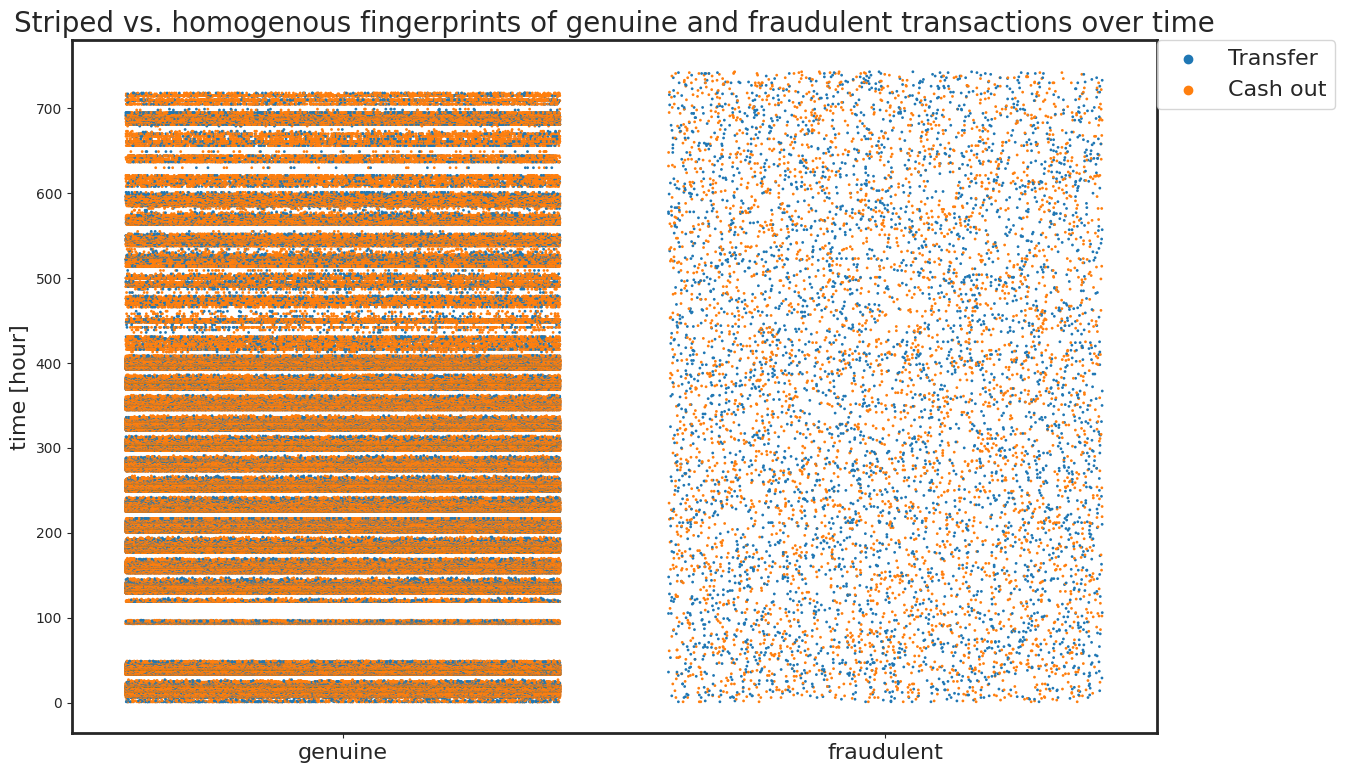

In [22]:
ax = plotStrip(Y[:limit], X.step[:limit], X.type[:limit])
ax.set_ylabel('time [hour]', size = 16)
ax.set_title('Striped vs. homogenous fingerprints of genuine and fraudulent \
transactions over time', size = 20);

### 5.2. Dispersión de las transacciones en los montos
Los 2 gráficos muestran que aunque  la presencia de fraude en una transacción puede ser discernida por el monto de la transacción original, la variable creada de error en el balance es más efectiva en hacer esta distinción.

C:\Users\luist\AppData\Local\Temp\ipykernel_2460\442509842.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
C:\Users\luist\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
C:\Users\luist\AppData\Local\Temp\ipykernel_2460\3687901914.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)


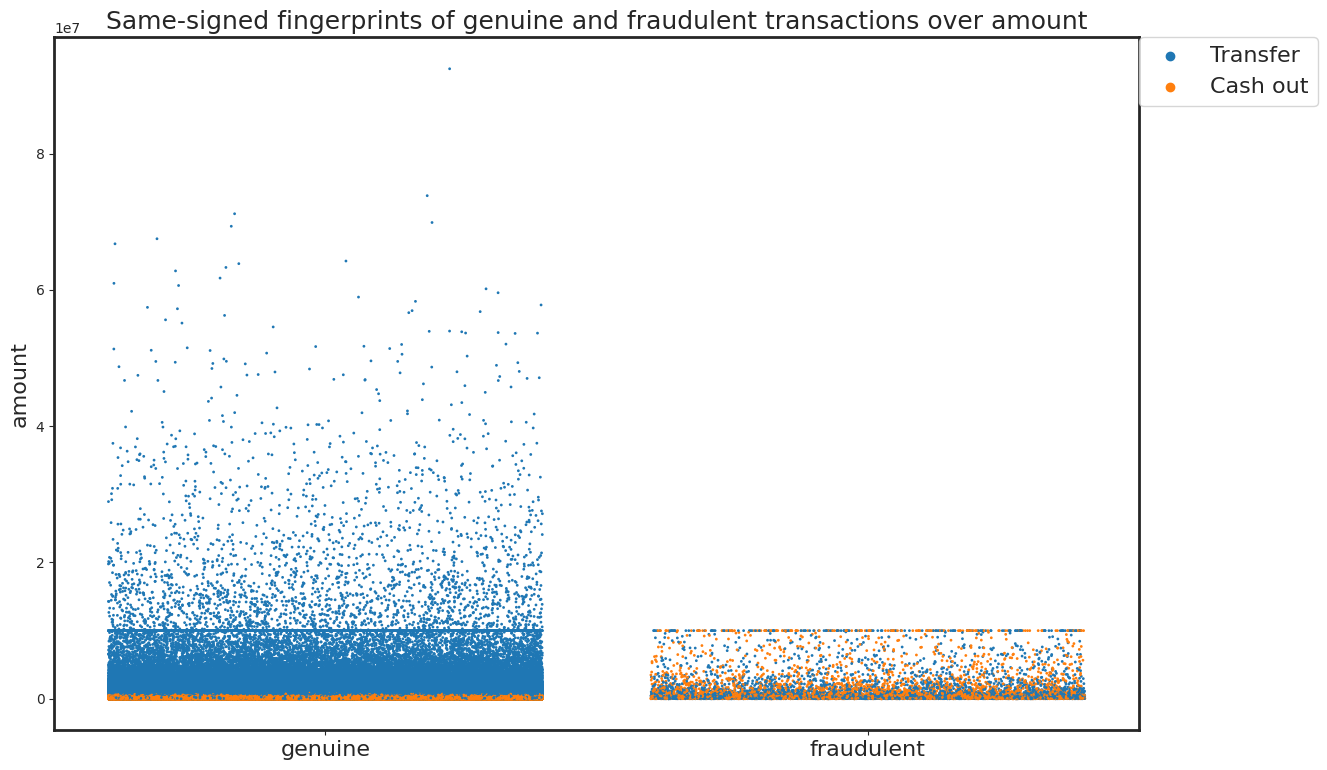

In [23]:
limit = len(X)
ax = plotStrip(Y[:limit], X.amount[:limit], X.type[:limit], figsize = (14, 9))
ax.set_ylabel('amount', size = 16)
ax.set_title('Same-signed fingerprints of genuine \
and fraudulent transactions over amount', size = 18);

### 5.3. Dispersión de los errores en el balance en las cuentas receptoras

C:\Users\luist\AppData\Local\Temp\ipykernel_2460\1755144090.py:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
C:\Users\luist\AppData\Roaming\Python\Python310\site-packages\seaborn\_oldcore.py:200: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if palette in QUAL_PALETTES:
C:\Users\luist\AppData\Local\Temp\ipykernel_2460\3687901914.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['genuine', 'fraudulent'], size = 16)


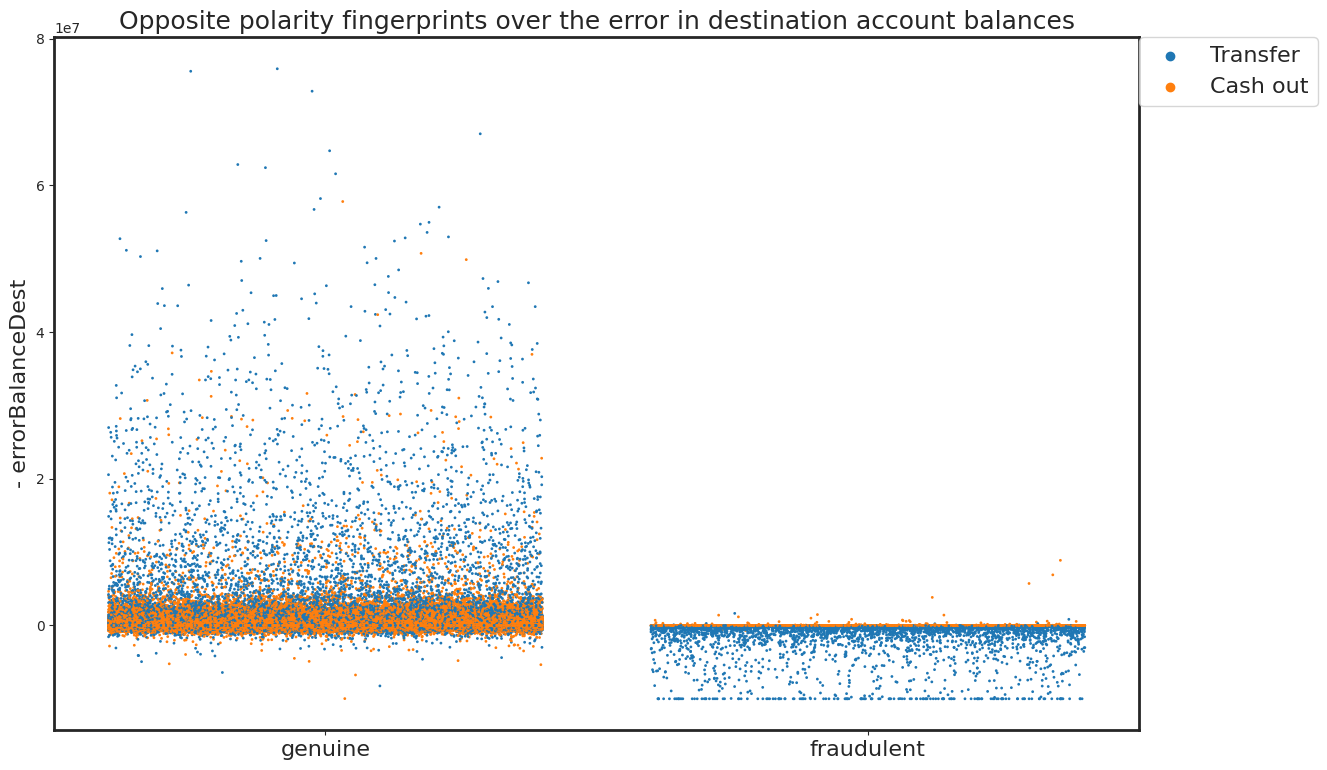

In [24]:
limit = len(X)
ax = plotStrip(Y[:limit], - X.errorBalanceDest[:limit], X.type[:limit], \
              figsize = (14, 9))
ax.set_ylabel('- errorBalanceDest', size = 16)
ax.set_title('Opposite polarity fingerprints over the error in \
destination account balances', size = 18);

# Definición de conjunto de entramiento y test

In [25]:
X_sub = X.sample(n = 100000, random_state= 22)
Y_sub = Y.sample(n = 100000, random_state= 22)

In [90]:
df_c = pd.concat([X, Y], axis=1)
df_c = df_c.sample(n = 10000, random_state= 22)
df_c
Y_sub = df_c['isFraud']
Y_sub
X_sub = df_c[['step', 'type', 'amount', 'oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest', 'errorBalanceOrig', 'errorBalanceDest']]
X_sub

,step,type,amount,oldBalanceOrig,newBalanceOrig,oldBalanceDest,newBalanceDest,errorBalanceOrig,errorBalanceDest
4559928,327,1,539307.42,361787.37,0.00,1127658.08,1666965.50,177520.05,0.000000e+00
3661435,275,1,84542.90,0.00,0.00,1069891.14,1154434.03,84542.90,1.000000e-02
274299,15,1,155126.18,48774.00,0.00,919620.49,1074746.67,106352.18,0.000000e+00
5088257,355,1,127298.09,14606.00,0.00,8870710.37,8998008.47,112692.09,-1.000000e-02
2164679,184,1,270955.21,0.00,0.00,1432038.71,1702993.92,270955.21,0.000000e+00
...,...,...,...,...,...,...,...,...,...
6125621,540,1,319001.47,308583.00,0.00,115152.22,434153.69,10418.47,-5.820766e-11
1543485,154,1,256534.35,305978.00,49443.65,0.00,256534.35,0.00,0.000000e+00
3853669,283,1,98898.04,202.00,0.00,728610.15,827508.19,98696.04,1.164153e-10
4424505,322,1,255414.20,0.00,0.00,422819.00,678233.20,255414.20,0.000000e+00


In [91]:
X_train, X_test, y_train, y_test = train_test_split(X_sub, Y_sub, random_state=22, stratify = Y_sub)

# Modelo logístico 

In [92]:
#instanciamos la regresión logística
logreg = LogisticRegression().fit(X_train, y_train)

In [93]:
print("Test set score: ", logreg.score(X_test, y_test))
print("Train set score: ",logreg.score(X_train, y_train))

Test set score:  0.998
Train set score:  0.9973333333333333


In [94]:
logreg = LogisticRegression()

In [95]:
scores = cross_val_score(logreg, X_sub, Y_sub);
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.9955 0.996  0.999  0.998  0.9975]


In [96]:
scores = cross_val_score(logreg, X_sub, Y_sub, cv=10);
print("Cross-validation scores: {}".format(scores))

Cross-validation scores: [0.995 0.997 0.996 0.996 0.999 0.999 0.999 0.997 0.997 0.998]


In [97]:
print("Average cross-validation score: ", scores.mean())

Average cross-validation score:  0.9972999999999999


In [98]:
kfold = KFold(n_splits=3, shuffle=True, random_state=22)
print("Cross-validation scores:\n{}".format(cross_val_score(logreg, X_sub, Y_sub, cv=kfold)))

Cross-validation scores:
[0.99730054 0.99789979 0.99729973]


# Validación cruzada estratificada con pipeline

In [99]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.preprocessing import MinMaxScaler

# Estratificado pipeline y SVM

In [100]:
from sklearn.pipeline import Pipeline
pipe = Pipeline([("scaler", MinMaxScaler()), ("svm", SVC())])

In [101]:
#Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])
pipe.fit(X_train, y_train)

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [102]:
Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

Pipeline(steps=[('scaler', MinMaxScaler()), ('svm', SVC())])

In [103]:
print("Test score: ", (pipe.score(X_test, y_test)))

Test score:  0.9968


In [104]:
param_grid = {'svm__C': [0.001, 0.01, 0.1, 1, 10, 100], 
              'svm__gamma': [0.001, 0.01, 0.1, 1, 10, 100]}

grid = GridSearchCV(pipe, param_grid=param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best cross-validation accuracy: {:.4f}".format(grid.best_score_))
print("Test set score: {:.4f}".format(grid.score(X_test, y_test)))
print("Best parameters: {}".format(grid.best_params_))

Best cross-validation accuracy: 0.9977
Test set score: 0.9972
Best parameters: {'svm__C': 100, 'svm__gamma': 1}


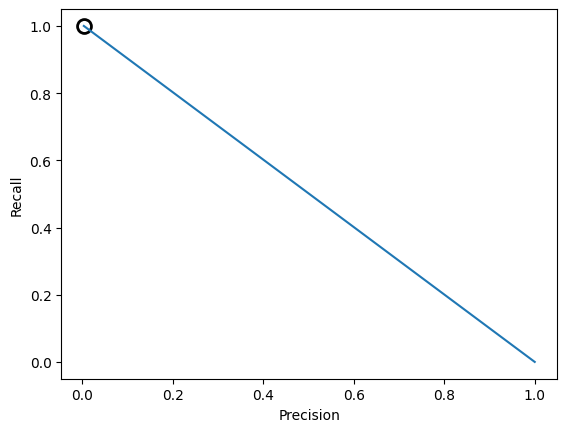

In [105]:
from sklearn.metrics import precision_recall_curve
svc = SVC(gamma=1, C=100).fit(X_train, y_train)
precision, recall, thresholds = precision_recall_curve(y_test, svc.decision_function(X_test))
close_zero = np.argmin(np.abs(thresholds))

plt.plot(precision[close_zero], recall[close_zero], 'o', markersize=10, label="threshold zero", fillstyle="none", c='k', mew=2)
plt.plot(precision, recall, label="precision recall curve")
plt.xlabel("Precision")
plt.ylabel("Recall");

In [106]:
from sklearn.model_selection import ParameterGrid, StratifiedKFold

In [107]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

# Pipeline Logistic Regression

In [108]:
# ajsutar porque este es el de Darit
param_grid = {'logisticregression__C': [0.01, 0.1, 1, 10, 100]}

pipe = make_pipeline(MinMaxScaler(), LogisticRegression(random_state=22))

log_gs = GridSearchCV(pipe, param_grid, cv=5, scoring='roc_auc')

log_grid = log_gs.fit(X_train, y_train)

In [109]:
log_grid.score(X_test, y_test)

0.9330357142857143

# Random Forest

In [110]:
from sklearn.ensemble import RandomForestClassifier

In [111]:
pipe = Pipeline([('preprocessing', StandardScaler()), ('classifier', SVC())])

In [112]:
param_grid = [{'classifier': [SVC()], 'preprocessing': [StandardScaler(), None],
               'classifier__gamma': [0.001, 0.01, 0.1, 1, 10, 100],
               'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100]},
              {'classifier': [RandomForestClassifier(n_estimators=100)],
               'preprocessing': [None], 'classifier__max_features': [1, 2, 3]}]

In [113]:
#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=0)
grid = GridSearchCV(pipe, param_grid, cv=5)
grid.fit(X_train, y_train)
print("Best params:\n{}\n".format(grid.best_params_))
print("Best cross-validation score: {:.6f}".format(grid.best_score_))
print("Test-set score: {:.6f}".format(grid.score(X_test, y_test)))

Best params:
{'classifier': RandomForestClassifier(max_features=2), 'classifier__max_features': 2, 'preprocessing': None}

Best cross-validation score: 0.999067
Test-set score: 0.999600


In [114]:
from sklearn.metrics import classification_report
rf = RandomForestClassifier(n_estimators=100, random_state=22, max_features=3)
rf.fit(X_train, y_train)
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2492
           1       1.00      0.88      0.93         8

    accuracy                           1.00      2500
   macro avg       1.00      0.94      0.97      2500
weighted avg       1.00      1.00      1.00      2500



In [115]:
precision_rf, recall_rf, thresholds_rf = precision_recall_curve(y_test, rf.predict_proba(X_test)[:, 1])

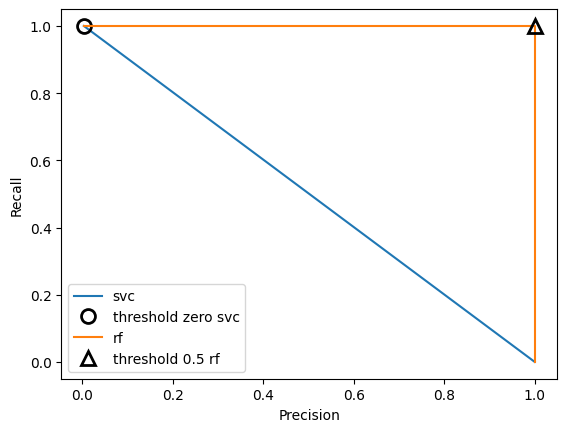

In [116]:
plt.plot(precision, recall, label="svc")
plt.plot(precision[close_zero], recall[close_zero], 'o', 
         markersize=10, label="threshold zero svc", fillstyle="none", c='k', mew=2)
plt.plot(precision_rf, recall_rf, label="rf")

close_default_rf = np.argmin(np.abs(thresholds_rf - 0.5))
plt.plot(precision_rf[close_default_rf], recall_rf[close_default_rf], '^', c='k',
         markersize=10, label="threshold 0.5 rf", fillstyle="none", mew=2)
plt.xlabel("Precision")
plt.ylabel("Recall")
plt.legend(loc="best");

In [119]:
from sklearn.metrics import f1_score
print("f1_score of random forest: {:.3f}".format(f1_score(y_test, rf.predict(X_test))))
print("f1_score of svc: {:.3f}".format(f1_score(y_test, svc.predict(X_test))))
print("f1_score of log: {:.3f}".format(f1_score(y_test, log_grid.predict(X_test))))

f1_score of random forest: 0.933
f1_score of svc: 0.000
f1_score of log: 0.222


In [120]:
#svc
print(classification_report(y_test, svc.predict(X_test)))

#regresion log
print(classification_report(y_test, log_grid.predict(X_test)))

#random forest
print(classification_report(y_test, rf.predict(X_test)))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2492
           1       0.00      0.00      0.00         8

    accuracy                           1.00      2500
   macro avg       0.50      0.50      0.50      2500
weighted avg       0.99      1.00      1.00      2500

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2492
           1       1.00      0.12      0.22         8

    accuracy                           1.00      2500
   macro avg       1.00      0.56      0.61      2500
weighted avg       1.00      1.00      1.00      2500

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2492
           1       1.00      0.88      0.93         8

    accuracy                           1.00      2500
   macro avg       1.00      0.94      0.97      2500
weighted avg       1.00      1.00      1.00      2500



d:\Archivos de Programas\Python\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Archivos de Programas\Python\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
d:\Archivos de Programas\Python\lib\site-packages\sklearn\metrics\_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
